In [ ]:
import pandas as pd
import scipy
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

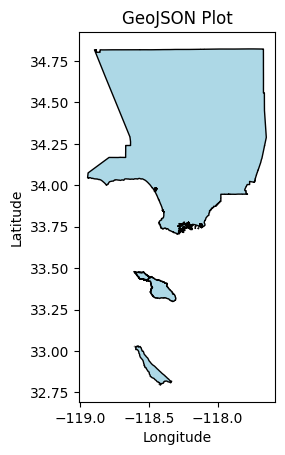

In [46]:
import geopandas as gpd

# Load the GeoJSON file
gdf = gpd.read_file("Data/county_boundary/County_Boundary.geojson")

# Plot the GeoDataFrame
gdf.plot(color='lightblue', edgecolor='black')  # Customize colors as needed
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GeoJSON Plot")
plt.show()

In [ ]:
from tqdm.auto import tqdm


def get_meshgrid(step_size=2):
    step_latitude = step_size/111
    step_longitude = step_size/92

    polygon = gdf.geometry.unary_union
    (minx, miny, maxx, maxy) = polygon.bounds

    x = np.arange(minx, maxx, step_latitude)
    y = np.arange(miny, maxy, step_longitude)

    xx, yy = np.meshgrid(x, y)

    # Flatten and create shapely Points
    points = [Point(xy) for xy in zip(xx.ravel(), yy.ravel())]
    # Filter points within the polygon
    mesh_points = [point for point in tqdm(points) if polygon.contains(point)]
    return gpd.GeoDataFrame(geometry=mesh_points)


mesh_gdf = get_meshgrid(step_size=1)

C:\Users\thiba\AppData\Local\Temp\ipykernel_23216\1912887315.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf.geometry.unary_union
100%|██████████| 27115/27115 [06:29<00:00, 69.62it/s]


In [ ]:
mesh_gdf['latitude'] = mesh_gdf.geometry.y
mesh_gdf['longitude'] = mesh_gdf.geometry.x

# Select only the latitude and longitude columns and save to a CSV file

<Axes: >

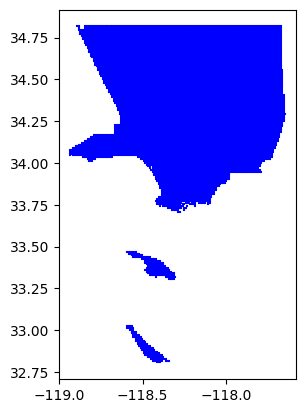

In [71]:
%matplotlib inline
mesh_gdf.plot(marker='+', color='blue', markersize=1)

In [128]:
values = pd.read_csv("Data/locations.csv")
values[["latitude", "longitude"]] = values["coordinates"].str.split(",", expand=True).astype(float)

Text(0.5, 0, 'Interpolated Data')

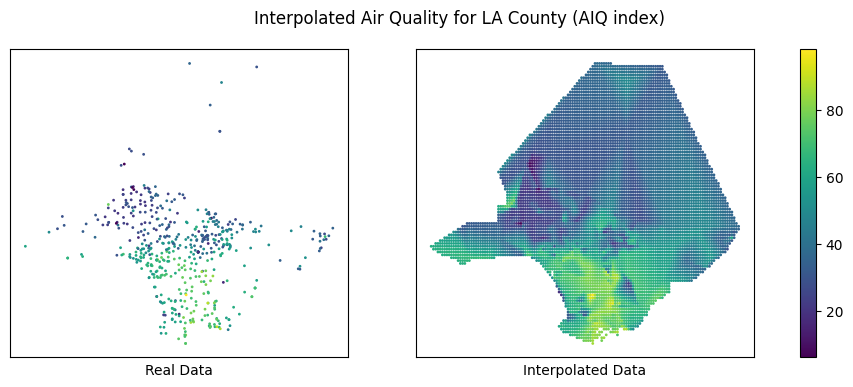

In [159]:
from scipy.interpolate import griddata
meshpoints = mesh_gdf[['latitude', 'longitude']].to_numpy()
points = values[["latitude", "longitude"]].to_numpy()
points_value = values["AQI"].astype(float).to_numpy()

new_values = griddata(points, points_value, meshpoints, method='linear')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

scatter1 = axs[0].scatter(points[:, 1], points[:, 0], c=points_value, s=1)
scatter2 = axs[1].scatter(meshpoints[:, 1], meshpoints[:, 0], c=new_values, s=1)
fig.colorbar(scatter1, ax=axs, orientation='vertical')
axs[0].set_xticks([]), axs[0].set_yticks([]), axs[1].set_xticks([]), axs[1].set_yticks([])

plt.suptitle(f"Interpolated Air Quality for LA County (AIQ index)")
axs[0].set_xlabel("Real Data")
axs[1].set_xlabel("Interpolated Data")

In [168]:
mesh_gdf["AIQ"] = new_values
mesh_gdf[['latitude', 'longitude', "AIQ"]].dropna(subset="AIQ").to_csv('Data/pollution_location.csv', index=False)

In [ ]:
# Assuming your GeoDataFrame is called 'gdf' and contains Point geometries
# Extract latitude and longitude
mesh_censors_gdf = get_meshgrid(step_size=2)
mesh_censors_gdf['latitude'] = mesh_censors_gdf.geometry.y
mesh_censors_gdf['longitude'] = mesh_censors_gdf.geometry.x

# Select only the latitude and longitude columns and save to a CSV file
mesh_censors_gdf[['latitude', 'longitude']].to_csv('Data/censors_location.csv', index=False)